In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.datasets import cifar10

tf.__version__

'2.8.0'

In [2]:
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])
print(len(gpus), "Physical GPUs Configured")

1 Physical GPUs Configured


In [3]:
def make_lab_arrays(image_set):
    l_array = []
    lab_array = []

    for image in image_set:
        lab_image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        l_channel = l_channel/255
        a_channel = (a_channel-128)/255
        b_channel = (b_channel-128)/255
        recombined = cv2.merge([l_channel,a_channel,b_channel])

        l_array.append(np.expand_dims(l_channel,axis=2))
        lab_array.append(recombined)

    return np.array(l_array), np.array(lab_array)

In [4]:
def lab2rgb(image):
    l_channel, a_channel, b_channel = cv2.split(image)
    l_channel = l_channel * 255
    a_channel = (a_channel*255)+128
    b_channel = (b_channel*255)+128
    recombined = cv2.merge([l_channel,a_channel,b_channel])
    converted = cv2.cvtColor(recombined.astype(np.uint8),cv2.COLOR_LAB2RGB)
    return converted

In [5]:
(pre_train, _), (pre_test, _) = cifar10.load_data()


X_train, y_train = make_lab_arrays(pre_train)
X_test, y_test = make_lab_arrays(pre_test[:100])

dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(128)

In [6]:
def downsample(filters):

  result = tf.keras.Sequential()
  result.add(layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',use_bias=False))

  result.add(layers.BatchNormalization())
  result.add(layers.LeakyReLU())

  return result

In [7]:
def upsample(filters):

  result = tf.keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, kernel_size=3, strides=1, padding='same',use_bias=False))

  result.add(layers.BatchNormalization())
  result.add(layers.Dropout(0.3))
  result.add(layers.LeakyReLU())

  return result

In [8]:
def v2_generator():

    inputs = layers.Input(shape=[32,32,1])

    down_stack = [
        downsample(64),
        downsample(128),
        downsample(256)
    ]

    up_stack = [
        upsample(256),
        upsample(128),
        upsample(64)
    ]

    last = layers.Conv2DTranspose(3,kernel_size=(3,3),activation='sigmoid',padding='same')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [9]:
def make_discriminator():

    model = keras.Sequential()

    model.add(layers.Conv2D(32,kernel_size=(5,5),strides=1,padding='same',input_shape=(32,32,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(32,kernel_size=(5,5),strides=1,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64,kernel_size=(5,5),strides=2,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64,kernel_size=(5,5),strides=2,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128,kernel_size=(5,5),strides=4,padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128,kernel_size=(5,5),strides=4,padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [10]:
gen_loss_tracker = metrics.Mean('gen_loss',dtype=tf.float32)
disc_loss_tracker = metrics.Mean('disc_loss',dtype=tf.float32)

In [11]:
cross_entropy = losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss   
    return total_loss

def generator_loss(fake_output):
    disc_loss = cross_entropy(tf.ones_like(fake_output),fake_output)
    return disc_loss

In [12]:
@tf.function
def gen_step(gray_batch):

    with tf.GradientTape() as gen_tape:
        generated_batch = generator(gray_batch,training=True)
        generated_disc_output = discriminator(generated_batch,training=False)
        gen_loss = generator_loss(generated_disc_output)
      
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    gen_loss_tracker(gen_loss)

In [13]:
@tf.function
def disc_step(gray_batch,color_batch):
    
    with tf.GradientTape() as disc_tape:
        generated_batch = generator(gray_batch,training=False)
        generated_disc_output = discriminator(generated_batch,training=True)
        real_disc_output = discriminator(color_batch,training=True)
        disc_loss = discriminator_loss(real_disc_output,generated_disc_output)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    disc_loss_tracker(disc_loss)

In [14]:
generator = v2_generator()
generator_optimizer = optimizers.Adam(0.0005)

discriminator = make_discriminator()
discriminator_optimizer = optimizers.Adam(0.0005)

In [15]:
gen_dir = 'logs/generator'
gen_summary_writer = tf.summary.create_file_writer(gen_dir)

disc_dir = 'logs/discriminator'
disc_summary_writer = tf.summary.create_file_writer(disc_dir)

In [25]:
epochs = 100

for epoch in tqdm(range(epochs)):

    for gray_batch,color_batch in dataset:
        disc_step(gray_batch,color_batch)

    with disc_summary_writer.as_default():
        tf.summary.scalar('disc_loss',disc_loss_tracker.result(),step=epoch)

    for gray_batch,color_batch in dataset:
        gen_step(gray_batch)

    with gen_summary_writer.as_default():
        tf.summary.scalar('gen_loss',gen_loss_tracker.result(),step=epoch)

    disc_loss_tracker.reset_states()
    gen_loss_tracker.reset_states()

100%|███████████████████████████████████████| 100/100 [1:53:32<00:00, 68.13s/it]


In [26]:
def show_test_images(count=5):

    y_pred = generator(X_test).numpy()

    fig,ax = plt.subplots(count,3,figsize=(12,4*count))
    for idx,row in enumerate(ax):
        

        row[0].imshow(X_test[idx],cmap='gray')
        row[1].imshow(lab2rgb(y_pred[idx]))
        row[2].imshow(lab2rgb(y_test[idx]))

        for axis in row:
            axis.set_xticks([])
            axis.set_yticks([])
    fig.set_facecolor('#FFFFFF')
    ax[0][0].set_title('Input',fontsize=32);
    ax[0][1].set_title('Colorized',fontsize=32);
    ax[0][2].set_title('True',fontsize=32);
    return fig

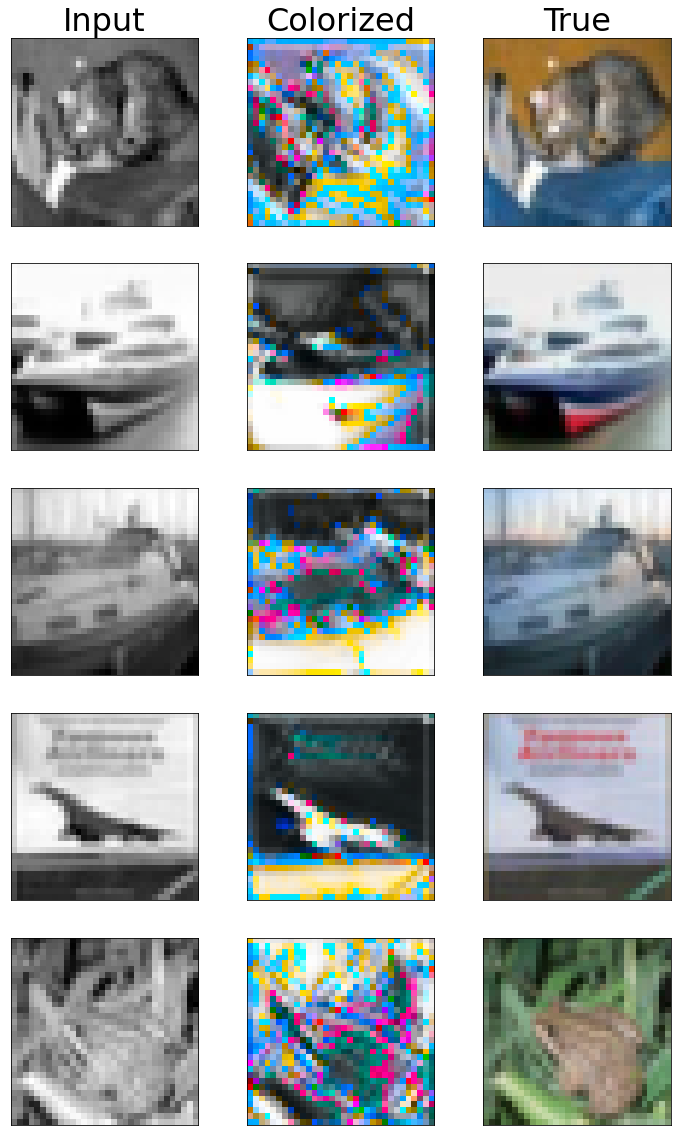

In [27]:
show_test_images();